In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from IPython.display import HTML
from __future__ import print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np

from pydrake.all import (
    SolutionResult
)
from underactuated import (
    PlanarRigidBodyVisualizer
)
import math
import numpy as np
import random

from pydrake.all import (
    DirectCollocation, 
    FloatingBaseType,
    PiecewisePolynomial, 
    RigidBodyTree, 
    RigidBodyPlant,
    SolutionResult
)
from pydrake.examples.acrobot import AcrobotPlant
from underactuated import (
    PlanarRigidBodyVisualizer
)

expmt = "acrobot"
seed  = 1776

# from dircol import make_real_dircol_mp
dircol = None
def make_real_dircol_mp(expmt="cartpole", seed=1776):
    global dircol
    # TODO: use the seed in some meaningful way:
    # https://github.com/RobotLocomotion/drake/blob/master/systems/stochastic_systems.h

    assert expmt in ("cartpole", "acrobot")
    # expmt = "cartpole" # State: (x, theta, x_dot, theta_dot) Input: x force
    # expmt = "acrobot" # State: (theta1, theta2, theta1_dot, theta2_dot) Input: Elbow torque

    if expmt == "cartpole":
        tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                             FloatingBaseType.kFixed)
        plant = RigidBodyPlant(tree)
    else:
        tree = RigidBodyTree("/opt/underactuated/src/acrobot/acrobot.urdf",
                         FloatingBaseType.kFixed)
        plant = AcrobotPlant()

    context = plant.CreateDefaultContext()

    if expmt == "cartpole":
        dircol = DirectCollocation(plant, context, num_time_samples=21,
                                   minimum_timestep=0.1, maximum_timestep=0.4)
    else:
        dircol = DirectCollocation(plant, context, num_time_samples=21,
                               minimum_timestep=0.05, maximum_timestep=0.2)

    dircol.AddEqualTimeIntervalsConstraints()

    if expmt == "acrobot":
        # Add input limits.
        torque_limit = 8.0  # N*m.
        u = dircol.input()
        dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
        dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = (0., 0., 0., 0.)
    dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                    dircol.initial_state())
    # More elegant version is blocked on drake #8315:
    # dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

    if expmt == "cartpole":
        final_state = (0., math.pi, 0., 0.)
    else:
        final_state = (math.pi, 0., 0., 0.)
    dircol.AddBoundingBoxConstraint(final_state, final_state,
                                    dircol.final_state())
    # dircol.AddLinearConstraint(dircol.final_state() == final_state)

    R = 10  # Cost on input "effort".
    u = dircol.input()
    dircol.AddRunningCost(R*u[0]**2)

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    initial_x_trajectory = \
        PiecewisePolynomial.FirstOrderHold([0., 4.],
                                           np.column_stack((initial_state,
                                                            final_state)))
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    print(id(dircol))
    return dircol

dircol = make_real_dircol_mp(expmt=expmt, seed=seed)

# Explcitly set the cost function here.
# R = 10  # Cost on input "effort".
# u = dircol.input()
# dircol.AddRunningCost(R*u[0]**2)

140459141346416


140459141346416
used solver:  SNOPT


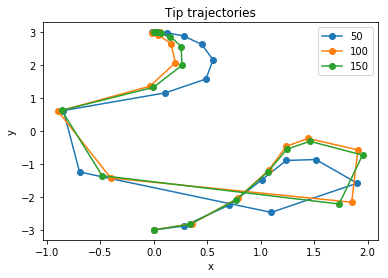

In [5]:
plt.figure()
plt.title('Tip trajectories')
plt.xlabel('x')
plt.ylabel('y')

vis_cb_counter = 0
if expmt == "cartpole":
    def state_to_tip_coord(state_vec):
        # State: (x, theta, x_dot, theta_dot)
        x, theta, _, _ = state_vec
        pole_length = 0.5 # manually looked this up
        return (x-pole_length*np.sin(theta), pole_length-np.cos(theta))
else:
    def state_to_tip_coord(state_vec):
        # State: (theta1, theta2, theta1_dot, theta2_dot)
        theta1, theta2, _, _ = state_vec
        link1_length = 1
        link2_length = 2
        return (-link1_length*np.sin(theta1)  -link2_length*np.sin(theta1+theta2), 
                -link1_length*np.cos(theta1)  -link2_length*np.cos(theta1+theta2))
def MyVisualization(sample_times, values):
    global vis_cb_counter
    global state_to_tip_coord

    vis_cb_counter += 1
    if vis_cb_counter % 50 != 0:
        return
    
    coords = [state_to_tip_coord(state) for state in values.T]
    x, y = zip(*coords)
    plt.plot(x, y, '-o', label=vis_cb_counter)

print(id(dircol))
dircol.AddStateTrajectoryCallback(MyVisualization)

result = dircol.Solve()
assert(result == SolutionResult.kSolutionFound)
print("used solver: ", dircol.GetSolverId().name())

# plt.show()
plt.legend()

# x_trajectory = dircol.ReconstructStateTrajectory()

In [ ]:
print(dircol.ReconstructStateTrajectory())

In [ ]:
x_trajectory = dircol.ReconstructStateTrajectory()

if expmt == "cartpole":
    vis = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5])
else:
    print("created acrobot vis")
#     print(x_trajectory)
    vis = PlanarRigidBodyVisualizer(tree, xlim=[-4., 4.], ylim=[-4., 4.])
ani = vis.animate(x_trajectory, repeat=True)

# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

In [ ]:
u_trajectory = dircol.ReconstructInputTrajectory()
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

plt.figure()
plt.plot(times, u_values)
plt.xlabel('time (seconds)')
plt.ylabel('force (Newtons)')

plt.show()